<ipython-input-3-38f0280b1fb2>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  walkable_points['near_water'] = walkable_points.apply(


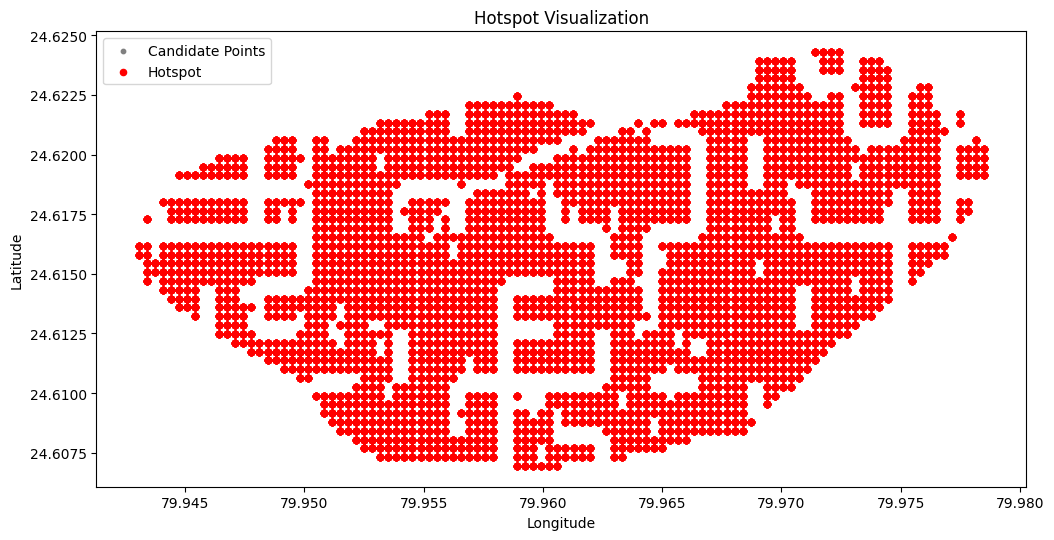

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic
import numpy as np


data = pd.read_csv("/content/env_data_2001.csv")

# Filter points classified as Walkable
walkable_points = data[(data['terrain_classification'] == 'Walkable')&(data['forest_type'] != 'Water')]

# Calculate proximity to water bodies
def is_near_water(lat, lon, water_points, max_distance_km=0.5):
    """Check if a point is near water within the max distance in kilometers."""
    for _, row in water_points.iterrows():
        water_coord = (row['latitude'], row['longitude'])
        if geodesic((lat, lon), water_coord).km <= max_distance_km:
            return True
    return False

# Filter water points
water_points = data[data['forest_type'] == 'Water']

# Add a column to indicate if a walkable point is near water
walkable_points['near_water'] = walkable_points.apply(
    lambda row: is_near_water(row['latitude'], row['longitude'], water_points), axis=1
)

# Keep only points that are near water
candidate_points = walkable_points[walkable_points['near_water']]

# Perform DBSCAN clustering
coords = candidate_points[['latitude', 'longitude']].values
db = DBSCAN(eps=0.005, min_samples=5, metric='haversine').fit(np.radians(coords))
candidate_points['cluster'] = db.labels_

# Keep only valid clusters (excluding noise labeled as -1)
valid_clusters = candidate_points[candidate_points['cluster'] != -1]

# Identify the cluster with the maximum points as the hotspot
hotspot_cluster = valid_clusters['cluster'].value_counts().idxmax()
hotspot_data = valid_clusters[valid_clusters['cluster'] == hotspot_cluster]

# Visualization
gdf = gpd.GeoDataFrame(candidate_points, geometry=gpd.points_from_xy(candidate_points.longitude, candidate_points.latitude))
hotspot_gdf = gpd.GeoDataFrame(hotspot_data, geometry=gpd.points_from_xy(hotspot_data.longitude, hotspot_data.latitude))

fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, color='gray', markersize=10, label="Candidate Points")
hotspot_gdf.plot(ax=ax, color='red', markersize=20, label="Hotspot")

# Highlight the bounding box
# polygon = Polygon(bounding_box)
# gpd.GeoSeries([polygon]).plot(ax=ax, edgecolor='blue', facecolor='none', label='Bounding Box')

plt.legend()
plt.title("Hotspot Visualization")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [ ]:
import pandas as pd
df = pd.read_csv("/content/env_data_2001_terrain_updt.xlsx")
df_summer = df[df['month'] == 'OCT']
len(df_summer)

3368

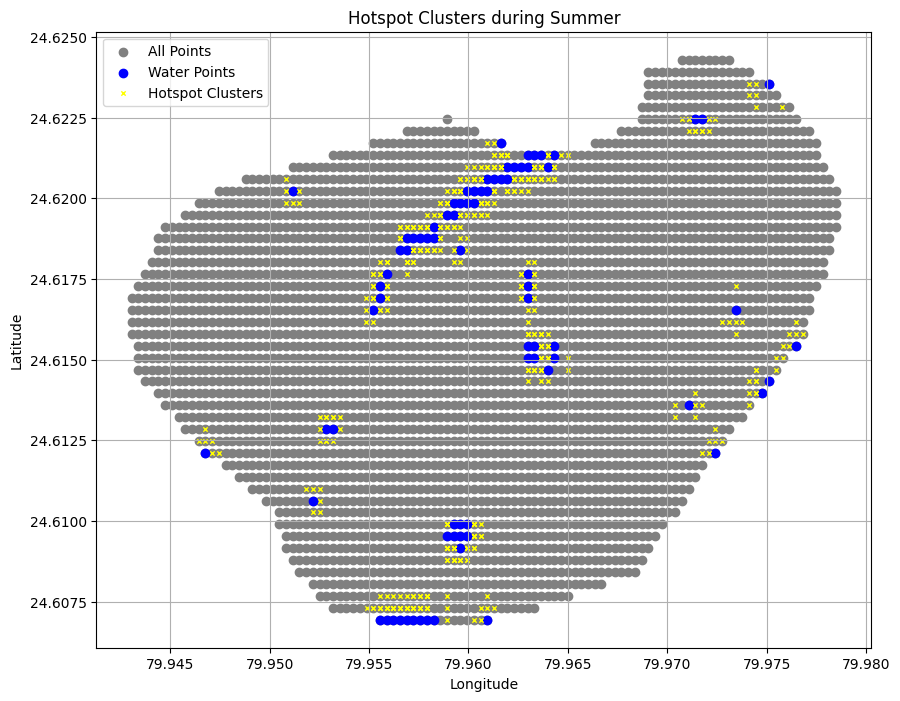

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

df = df_summer

# Identify water points
water_points = df[df['forest_type'] == 'Water'][['latitude', 'longitude']].values

# Candidate points for hotspots: Walkable terrain and not water
candidate_points = df[
    (df['terrain_classification'] == 'Walkable') & (df['forest_type'] != 'Water')
][['latitude', 'longitude']].values

# Build a KDTree for efficient nearest-neighbor search
tree = KDTree(candidate_points)

# Parameters
max_cluster_size = 6
min_cluster_size = 4
max_distance = 3  # Maximum allowed distance for clustering (adjust as needed)

# Cluster formation
clusters = []
for water_point in water_points:
    distances, indices = tree.query(water_point, k=len(candidate_points), distance_upper_bound=max_distance)
    valid_indices = indices[distances != np.inf][:max_cluster_size]
    if len(valid_indices) >= min_cluster_size:
        cluster_points = candidate_points[valid_indices]
        clusters.append(cluster_points)

# Visualization of clusters
plt.figure(figsize=(10, 8))
plt.scatter(df['longitude'], df['latitude'], c='gray', label='All Points')

# Water points in blue
plt.scatter(water_points[:, 1], water_points[:, 0], c='blue', label='Water Points', marker='o')

# Plot each cluster in yellow with bold 'x' markers
for i, cluster in enumerate(clusters):
    cluster_lats = cluster[:, 0]
    cluster_lons = cluster[:, 1]
    plt.scatter(cluster_lons, cluster_lats, marker='x', color='yellow', s=10, linewidths=1)

# Title and labels
plt.title("Hotspot Clusters during Summer")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.legend(['All Points', 'Water Points', 'Hotspot Clusters'])
plt.show()


In [ ]:
df = pd.read_csv("/content/env_data_2001_terrain_updt.xlsx")
df_monsoon = df[df['month'] == 'SEP']
len(df_monsoon)

3368

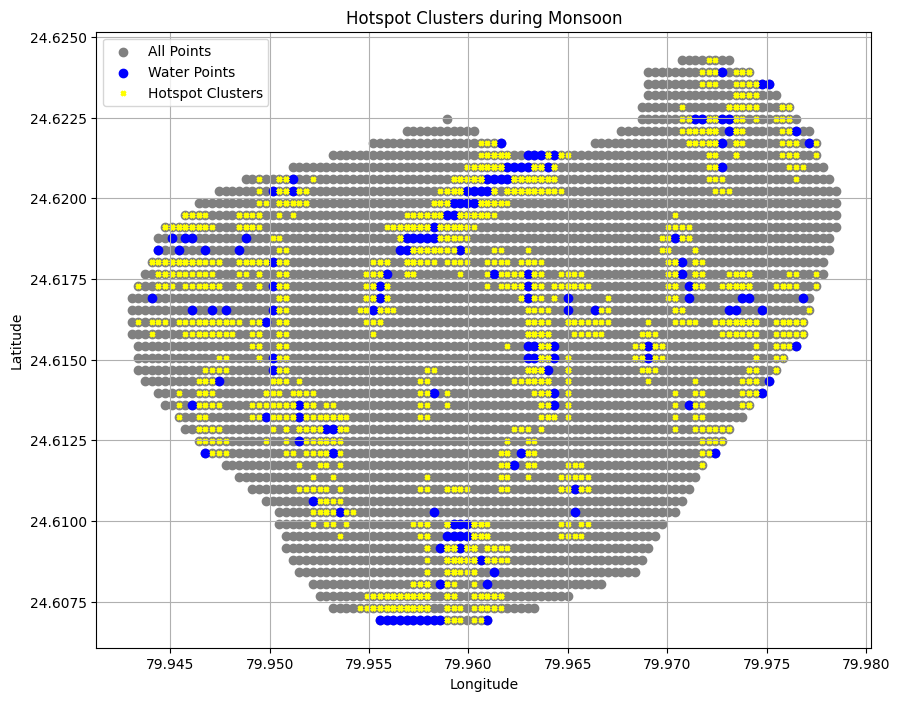

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

df = df_monsoon

# Identify water points
water_points = df[df['forest_type'] == 'Water'][['latitude', 'longitude']].values

# Candidate points for hotspots: Walkable terrain and not water
candidate_points = df[
    (df['terrain_classification'] == 'Walkable') & (df['forest_type'] != 'Water')
][['latitude', 'longitude']].values

# Build a KDTree for efficient nearest-neighbor search
tree = KDTree(candidate_points)

# Parameters
max_cluster_size = 12
min_cluster_size = 10
max_distance = 7  # Maximum allowed distance for clustering (adjust as needed)

# Cluster formation
clusters = []
for water_point in water_points:
    distances, indices = tree.query(water_point, k=len(candidate_points), distance_upper_bound=max_distance)
    valid_indices = indices[distances != np.inf][:max_cluster_size]
    if len(valid_indices) >= min_cluster_size:
        cluster_points = candidate_points[valid_indices]
        clusters.append(cluster_points)

# Visualization of clusters
plt.figure(figsize=(10, 8))
plt.scatter(df['longitude'], df['latitude'], c='gray', label='All Points')

# Water points in blue
plt.scatter(water_points[:, 1], water_points[:, 0], c='blue', label='Water Points', marker='o')

# Plot each cluster in yellow with bold 'x' markers
for i, cluster in enumerate(clusters):
    cluster_lats = cluster[:, 0]
    cluster_lons = cluster[:, 1]
    plt.scatter(cluster_lons, cluster_lats, marker='x', color='yellow', s=10, linewidths=2)

# Title and labels
plt.title("Hotspot Clusters during Monsoon")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.legend(['All Points', 'Water Points', 'Hotspot Clusters'])
plt.show()


Agent training and testing

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import random
import gym
from gym import spaces
from tqdm import tqdm

# Load the dataset
df = pd.read_csv("/content/env_data_2001_terrain_updt_SEP.xlsx")

# Step 1: Identify Hotspots
def find_hotspots(df, max_cluster_size=6, min_cluster_size=4, max_distance=3):
    """
    Identify hotspots based on water bodies and walkable terrain.
    """
    water_points = df[df['forest_type'] == 'Water'][['latitude', 'longitude']].values
    candidate_points = df[
        (df['terrain_classification'] == 'Walkable') & (df['forest_type'] != 'Water')
    ][['latitude', 'longitude']].values

    tree = KDTree(candidate_points)
    clusters = []

    for water_point in water_points:
        distances, indices = tree.query(water_point, k=len(candidate_points), distance_upper_bound=max_distance)
        valid_indices = indices[distances != np.inf][:max_cluster_size]
        if len(valid_indices) >= min_cluster_size:
            cluster_points = candidate_points[valid_indices]
            clusters.append(cluster_points)

    # Return all clusters
    return clusters

hotspots = find_hotspots(df)

# Step 2: Define the RL Environment
class TigerMovementEnv(gym.Env):
    def __init__(self, df, hotspots, bounding_box):
        super(TigerMovementEnv, self).__init__()
        self.df = df
        self.hotspots = hotspots
        self.bounding_box = Polygon(bounding_box)
        self.lat_lon_points = df[['latitude', 'longitude']].values

        # Action space: 8 possible movements (N, NE, E, SE, S, SW, W, NW)
        self.action_space = spaces.Discrete(8)

        # Observation space: Current lat-lon
        self.observation_space = spaces.Box(
            low=np.min(self.lat_lon_points, axis=0),
            high=np.max(self.lat_lon_points, axis=0),
            dtype=np.float32
        )

        # Initial state
        self.state = self._select_random_start_point()
        self.done = False

    def _select_random_start_point(self):
        valid_points = self.df[
            (self.df['terrain_classification'] != 'Cliff') &
            (self.df['forest_type'] != 'Water')
        ][['latitude', 'longitude']].values
        return random.choice(valid_points)

    def _get_neighbours(self, lat, lon):
        # Compute all neighbours in 8 directions
        lat_increment = 0.001
        lon_increment = 0.001
        neighbours = [
            (lat + lat_increment, lon),
            (lat - lat_increment, lon),
            (lat, lon + lon_increment),
            (lat, lon - lon_increment),
            (lat + lat_increment, lon + lon_increment),
            (lat - lat_increment, lon - lon_increment),
            (lat + lat_increment, lon - lon_increment),
            (lat - lat_increment, lon + lon_increment),
        ]
        # Filter points within bounding box and valid terrain
        valid_neighbours = [
            (n_lat, n_lon) for n_lat, n_lon in neighbours
            if self.bounding_box.contains(Point(n_lat, n_lon)) and
            not self._is_cliff_or_water(n_lat, n_lon)
        ]
        return valid_neighbours

    def _is_cliff_or_water(self, lat, lon):
        """
        Check if a point is of type Cliff or Water.
        """
        point_df = self.df[
            (self.df['latitude'] == lat) & (self.df['longitude'] == lon)
        ]
        if not point_df.empty:
            terrain = point_df.iloc[0]['terrain_classification']
            forest_type = point_df.iloc[0]['forest_type']
            return terrain == 'Cliff' or forest_type == 'Water'
        return False

    def _find_closest_hotspot(self):
        """
        Find the closest hotspot cluster to the current state.
        """
        current_lat, current_lon = self.state
        min_distance = float('inf')
        closest_cluster = None

        for cluster in self.hotspots:
            for hotspot_point in cluster:
                distance = geodesic(self.state, hotspot_point).meters
                if distance < min_distance:
                    min_distance = distance
                    closest_cluster = cluster

        return closest_cluster

    def step(self, action):
        if self.done:
            raise ValueError("Environment is already done.")

        # Decode action and move to the new state
        current_lat, current_lon = self.state
        neighbours = self._get_neighbours(current_lat, current_lon)
        if not neighbours:
            self.done = True
            reward = -10  # Penalty for being stuck
            return self.state, reward, self.done, {}

        next_lat, next_lon = neighbours[action % len(neighbours)]
        self.state = (next_lat, next_lon)

        # Find the closest hotspot cluster
        closest_hotspot_cluster = self._find_closest_hotspot()

        # Calculate reward
        reward = -1  # Penalize for each step
        for hotspot_point in closest_hotspot_cluster:
            distance_to_hotspot = geodesic(self.state, hotspot_point).meters
            if distance_to_hotspot < 50:  # Close to a hotspot
                reward += 100
                self.done = True
                break

        return self.state, reward, self.done, {}

    def reset(self):
        self.state = self._select_random_start_point()
        self.done = False
        return self.state

# Step 3: Train the RL Agent
def train_rl_agent(env, episodes=100):
    """
    Train the RL agent using Q-learning.
    """
    q_table = {}
    alpha = 0.1  # Learning rate
    gamma = 0.6  # Discount factor
    epsilon = 0.1  # Exploration rate

    for episode in tqdm(range(episodes), desc="Training Episodes"):
        state = env.reset()
        state_key = tuple(state)
        total_reward = 0

        for _ in range(100):  # Max steps per episode
            if state_key not in q_table:
                q_table[state_key] = np.zeros(env.action_space.n)

            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(q_table[state_key])  # Exploit

            next_state, reward, done, _ = env.step(action)
            next_state_key = tuple(next_state)
            total_reward += reward

            if next_state_key not in q_table:
                q_table[next_state_key] = np.zeros(env.action_space.n)

            # Update Q-value
            old_value = q_table[state_key][action]
            next_max = np.max(q_table[next_state_key])
            q_table[state_key][action] = old_value + alpha * (reward + gamma * next_max - old_value)

            state_key = next_state_key
            if done:
                break
        if episode % 10 == 0:
            print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    return q_table

# Initialize environment
bounding_box = [(24.619220023961386, 79.94468841841837),
                (24.61649485328929, 79.94271953513679),
                (24.614575904458537, 79.94339881414824),
                (24.61228241126299, 79.94639200718441),
                (24.610298657532, 79.95027566620982),
                (24.60881443524366, 79.95088874297181),
                (24.60726019913875, 79.95293412913196),
                (24.606572658511087, 79.9582553604233),
                (24.60669667877494, 79.95825536527397),
                (24.607002731909347, 79.96187451577414),
                (24.608426693570497, 79.96856557561885),
                (24.61152732237915, 79.97171057257866),
                (24.613574343971173, 79.97437766514028),
                (24.615808527401757, 79.97690490392651),
                (24.61965787171238, 79.97889752020046),
                (24.62214006002244, 79.97724776443728),
                (24.623511930413187, 79.97529033761457),
                (24.62463679368871, 79.97230075751973),
                (24.6240094687391, 79.96900155936194),
                (24.62239368365942, 79.96845269828208),
                (24.621646261181464, 79.96584836365336),
                (24.621643906484902, 79.96188020626808),
                (24.622447822744178, 79.95914497845294),
                (24.622509947771366, 79.95914515096338),
                (24.621203988647977, 79.95225248718403),
                (24.62052173681583, 79.94816292431844),
                (24.619220023961386, 79.94468841841837)]
env = TigerMovementEnv(df, hotspots, bounding_box)

# Train the agent
q_table = train_rl_agent(env)


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Training Episodes:   1%|          | 1/100 [00:00<00:33,  2.99it/s]

Episode 1: Total Reward = 99


Training Episodes:  12%|█▏        | 12/100 [00:18<01:11,  1.22it/s]

Episode 11: Total Reward = 96


Training Episodes:  22%|██▏       | 22/100 [00:34<02:24,  1.85s/it]

Episode 21: Total Reward = 72


Training Episodes:  31%|███       | 31/100 [00:43<02:00,  1.74s/it]

Episode 31: Total Reward = 83


Training Episodes:  41%|████      | 41/100 [00:49<00:26,  2.26it/s]

Episode 41: Total Reward = 99


Training Episodes:  51%|█████     | 51/100 [01:08<00:43,  1.14it/s]

Episode 51: Total Reward = 98


Training Episodes:  62%|██████▏   | 62/100 [01:14<00:21,  1.78it/s]

Episode 61: Total Reward = 94


Training Episodes:  71%|███████   | 71/100 [01:26<00:50,  1.75s/it]

Episode 71: Total Reward = 97


Training Episodes:  81%|████████  | 81/100 [01:43<00:49,  2.61s/it]

Episode 81: Total Reward = 96


Training Episodes:  91%|█████████ | 91/100 [01:53<00:07,  1.18it/s]

Episode 91: Total Reward = 98


Training Episodes: 100%|██████████| 100/100 [02:05<00:00,  1.26s/it]


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Path taken by the agent: [array([24.62023395, 79.95284535]), (24.62123395, 79.95284535), (24.62023395, 79.95184535)]
Total reward: 98


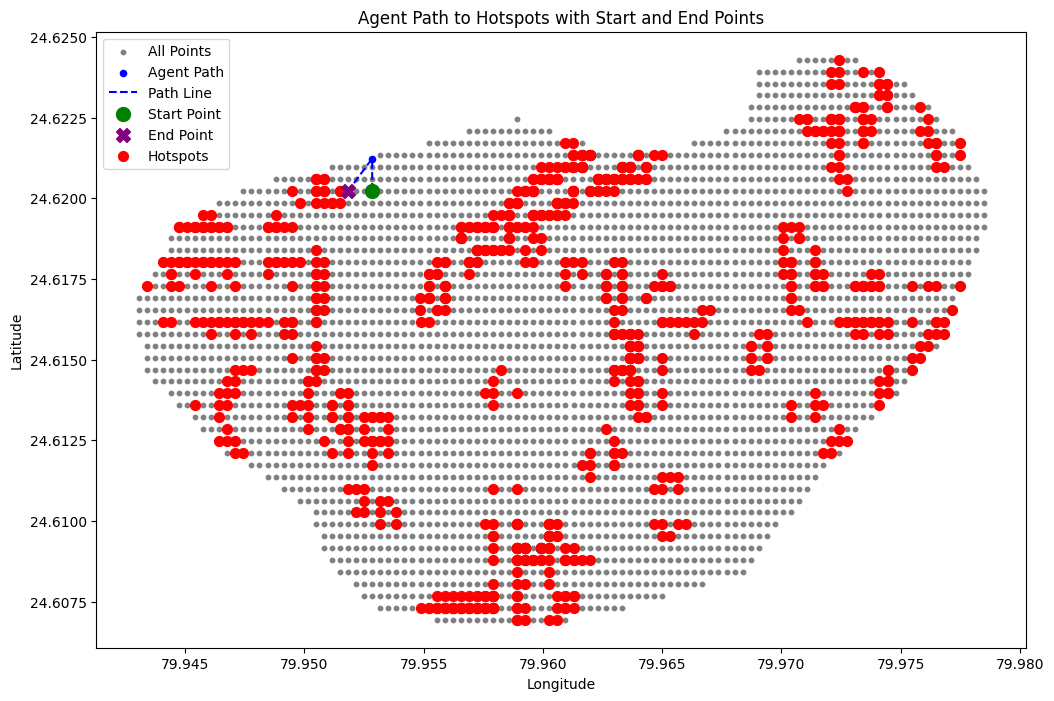

In [ ]:
# Step 1: Update the environment to record paths
class TigerMovementEnvWithPaths(TigerMovementEnv):
    def __init__(self, df, hotspots, bounding_box):
        super().__init__(df, hotspots, bounding_box)
        self.path = []  # Stores the path taken by the agent

    def reset(self):
        self.path = []  # Clear the path at the start of a new episode
        start_point = super().reset()
        self.path.append(start_point)  # Record the starting point
        return start_point

    def step(self, action):
        state, reward, done, info = super().step(action)
        self.path.append(state)  # Record each step
        return state, reward, done, info

# Step 2: Test the RL agent on the testing dataset
def test_rl_agent(env, q_table):
    """
    Test the trained RL agent on the environment and record paths.
    """
    state = env.reset()
    state_key = tuple(state)
    total_reward = 0

    for _ in range(100):  # Max steps per episode
        if state_key not in q_table:
            action = env.action_space.sample()  # Default to random if no Q-value exists
        else:
            action = np.argmax(q_table[state_key])

        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state_key = tuple(next_state)

        if done:
            break

    return env.path, total_reward

# Step 3: Load the testing dataset
test_df = pd.read_csv("/content/env_data_2001_terrain_updt_OCT.xlsx")

# Step 4: Initialize the environment for testing
test_env = TigerMovementEnvWithPaths(test_df, hotspots, bounding_box)

# Step 5: Test the RL agent
test_path, total_reward = test_rl_agent(test_env, q_table)

print(f"Path taken by the agent: {test_path}")
print(f"Total reward: {total_reward}")

# Step 6: Visualize the path with start and end points
def visualize_path_with_start_end(path, df, hotspots):
    """
    Visualize the path taken by the agent, including start and end points.
    """
    path_lats, path_lons = zip(*path)

    # Extract hotspot coordinates from all clusters
    hotspot_lats = []
    hotspot_lons = []
    for cluster in hotspots:
        for lat, lon in cluster:
            hotspot_lats.append(lat)
            hotspot_lons.append(lon)

    # Start and End Points
    start_lat, start_lon = path[0]
    end_lat, end_lon = path[-1]

    plt.figure(figsize=(12, 8))

    # Plot all data points
    plt.scatter(df['longitude'], df['latitude'], s=10, c='gray', label='All Points')

    # Plot the path
    plt.scatter(path_lons, path_lats, c='blue', s=20, label='Agent Path', zorder=2)
    plt.plot(path_lons, path_lats, c='blue', linestyle='--', label='Path Line', zorder=1)

    # Highlight start and end points
    plt.scatter(start_lon, start_lat, c='green', s=100, marker='o', label='Start Point', zorder=4)
    plt.scatter(end_lon, end_lat, c='purple', s=100, marker='X', label='End Point', zorder=4)

    # Highlight hotspots
    plt.scatter(hotspot_lons, hotspot_lats, c='red', s=50, label='Hotspots', zorder=3)

    # Add labels and legend
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.title('Agent Path to Hotspots with Start and End Points')
    plt.show()

# Visualize the path with start and end points
visualize_path_with_start_end(test_path, test_df, hotspots)
